In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import math
from influxdb_client import InfluxDBClient


# 1. 폰트 설정 및 라이브러리 import

In [16]:
from common import (
    sensor_types, sensor_type_mapping,
    get_influx_client, 
)


# 2. Influx DB 

In [17]:
# InfluxDB 연결
client, INFLUX_BUCKET = get_influx_client()
read_api = client.query_api()

# 센서 타입 필터 생성
sensor_filter = ' or '.join([f'r["type"] == "{t}"' for t in sensor_types])

# Flux 쿼리 작성
flux = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -1d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => {sensor_filter})
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
'''

# 데이터 쿼리 및 전처리
df = read_api.query_data_frame(flux)

if isinstance(df, list):
    df = pd.concat(df)

df = df.reset_index().rename(columns={"_time": "time"})
df = df.set_index("time")

# 데이터 확인
print("데이터 샘플:")
display(df.head())
print(f"데이터 크기: {df.shape}")


/opt/homebrew/anaconda3/lib/python3.12/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
from(bucket: "coffee-mqtt")
  |> range(start: -1d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => r["type"] == "co2" or r["type"] == "distance" or r["type"] == "humidity" or r["type"] == "illumination" or r["type"] == "infrared" or r["type"] == "pressure" or r["type"] == "temperature" or r["type"] == "infrared_and_visible" or r["type"] == "occupancy" or r["type"] == "battery_level" or r["type"] == "activity" or r["type"] == "battery")
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnin

데이터 샘플:


,index,result,table,_start,_stop,_value,_field,_measurement,location,type
time,,,,,,,,,,
2025-04-25 09:45:00+00:00,0,mean,0,2025-04-25 09:44:32.162940+00:00,2025-04-26 09:44:32.162940+00:00,31.0,value,sensor,2,battery
2025-04-25 09:50:00+00:00,1,mean,0,2025-04-25 09:44:32.162940+00:00,2025-04-26 09:44:32.162940+00:00,31.0,value,sensor,2,battery
2025-04-25 09:55:00+00:00,2,mean,0,2025-04-25 09:44:32.162940+00:00,2025-04-26 09:44:32.162940+00:00,31.0,value,sensor,2,battery
2025-04-25 10:00:00+00:00,3,mean,0,2025-04-25 09:44:32.162940+00:00,2025-04-26 09:44:32.162940+00:00,31.0,value,sensor,2,battery
2025-04-25 10:05:00+00:00,4,mean,0,2025-04-25 09:44:32.162940+00:00,2025-04-26 09:44:32.162940+00:00,31.0,value,sensor,2,battery


데이터 크기: (8945, 10)


### 냉장고의 경우 기온 관련 문제 발생 가능성 + 목적에 맞지 않으므로 데이터에서 제외

In [18]:
df = df[df["location"]!="냉장고 내부"]

In [19]:
# 센서 타입 한글 매핑
sensor_type_mapping = {
    'temperature': '실내 온도(°C)',
    'humidity': '상대습도(%)',
    'co2': '이산화탄소 농도(ppm)',
    'tvoc': '총휘발성유기화합물(ppb)',
    'pressure': '대기압(hPa)',
    'occupancy': '재실 여부',
    'activity': '활동 수준',
    'distance': '거리(cm)',
    'illumination': '조도(lux)',
    'infrared': '적외선',
    'infrared_and_visible': '적외선 및 가시광선',
    'battery': '배터리 상태',
    'battery_level': '배터리 잔량(%)'
}

# 불쾌지수 계산 함수
def calculate_discomfort_index(temp, humidity):
    """
    온도와 습도를 기반으로 불쾌지수 계산
    불쾌지수 = 0.81×온도 + 0.01×습도×(0.99×온도-14.3) + 46.3
    """
    return 0.81 * temp + 0.01 * humidity * (0.99 * temp - 14.3) + 46.3

# 불쾌지수 해석 함수
def interpret_discomfort_index(index):
    if index < 70:
        return "쾌적함"
    elif index < 75:
        return "약간 불쾌함"
    elif index < 80:
        return "불쾌함"
    else:
        return "매우 불쾌함"


# 시간에 따른 변수 변화

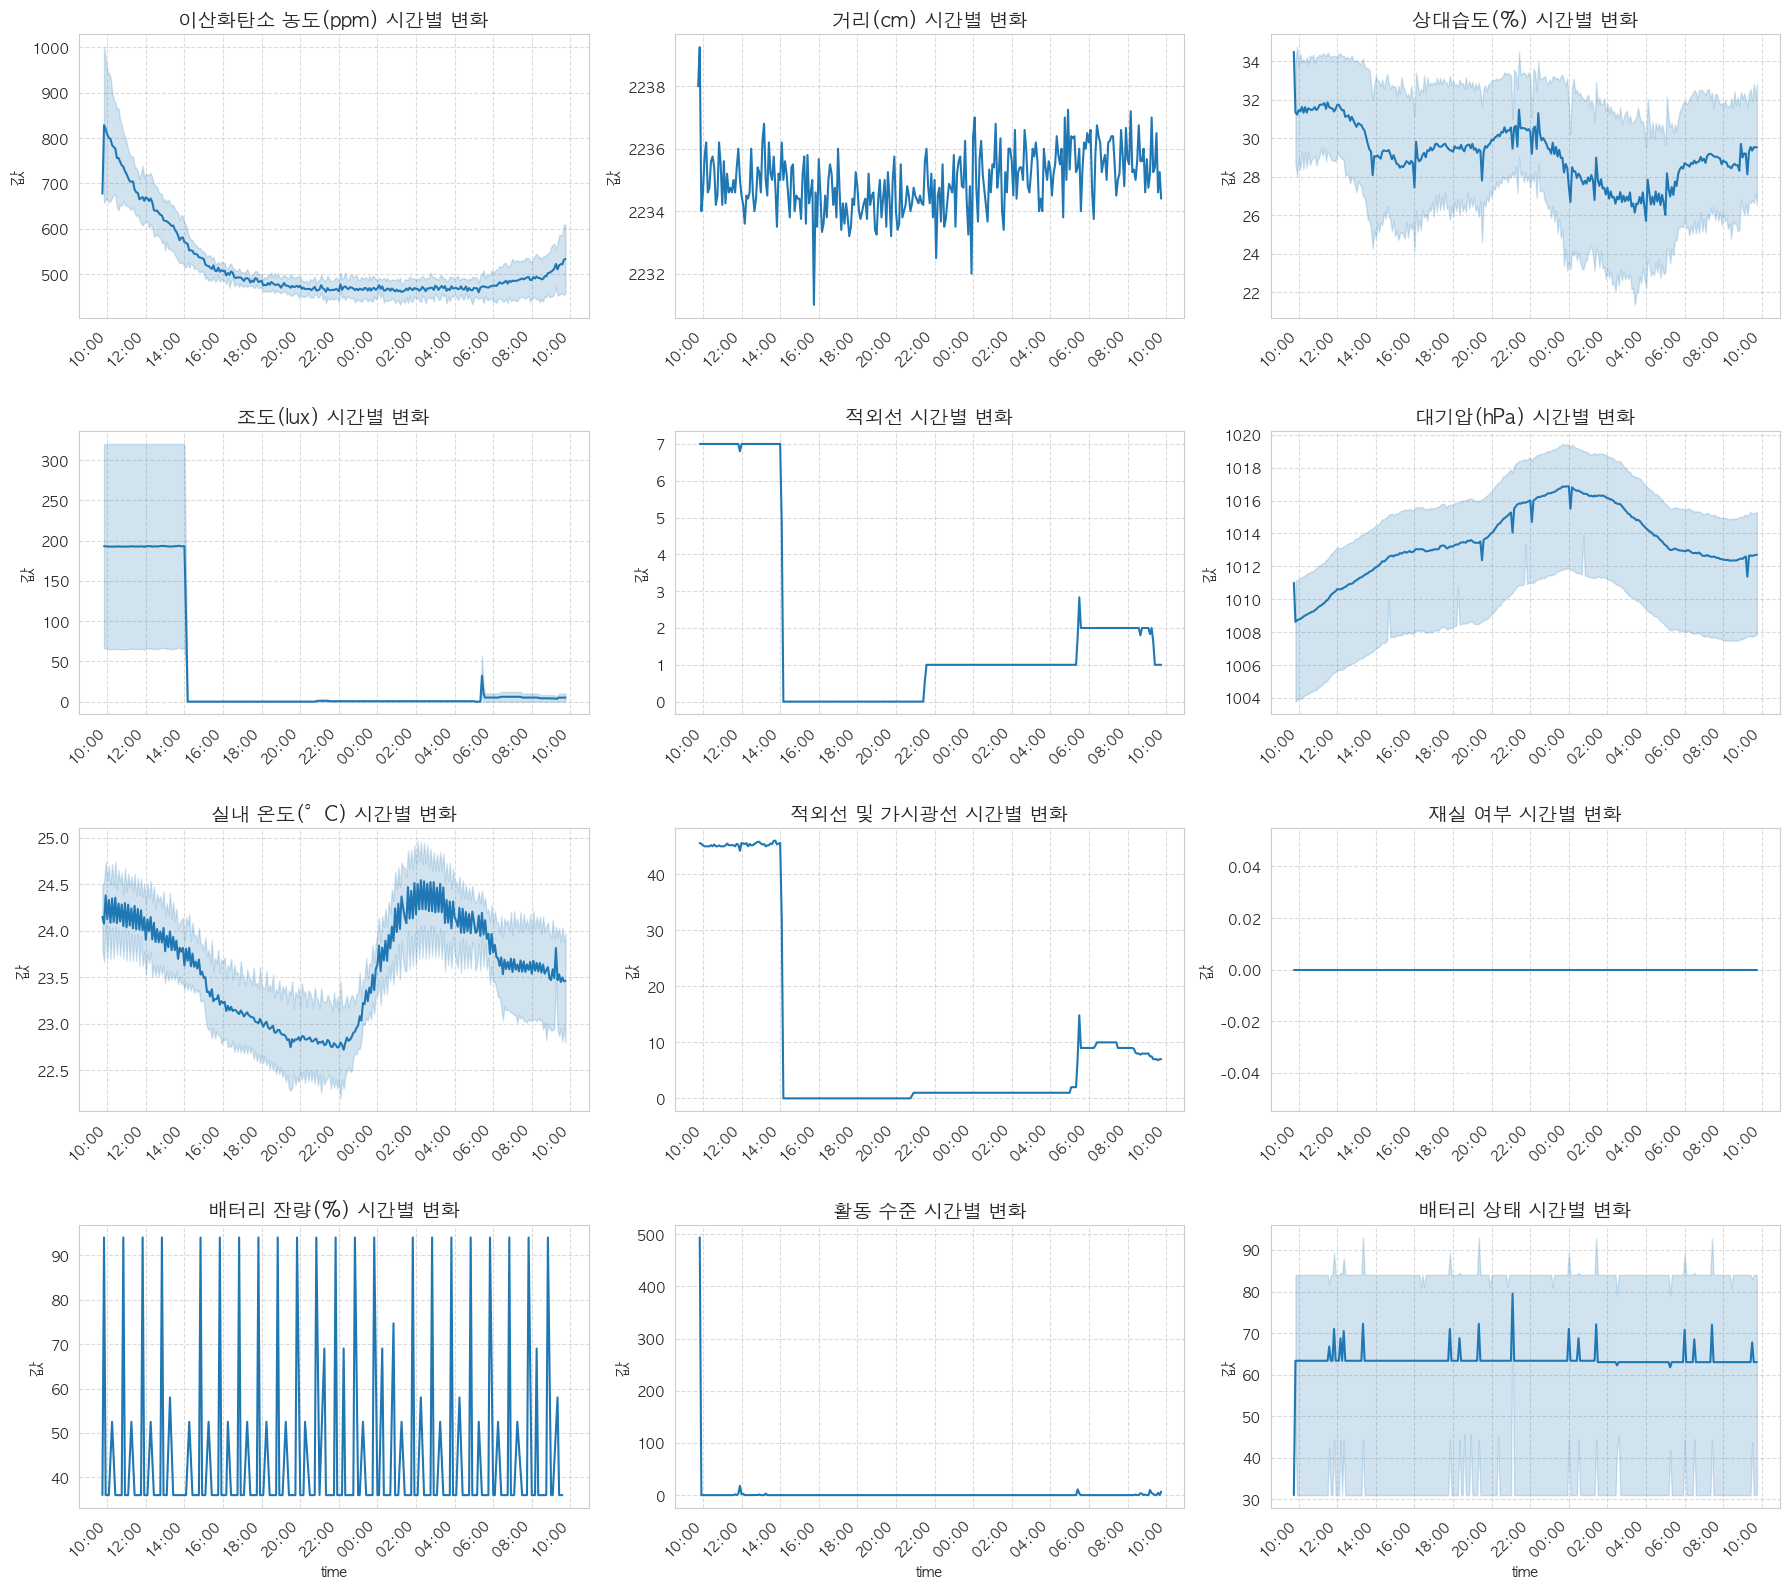

In [20]:
# 환경 모니터링 데이터 시각화 (한글 제목)
cols = 3
rows = math.ceil(len(sensor_types) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4), sharex=True)
axes = axes.flatten()

for i, t in enumerate(sensor_types):
    temp = df[df['type'] == t]
    if not temp.empty:
        # 데이터 시각화
        sns.lineplot(ax=axes[i], data=temp, x=temp.index, y='_value')
        
        # 한글 타이틀 적용
        korean_title = sensor_type_mapping.get(t, t)
        axes[i].set_title(f'{korean_title} 시간별 변화', fontsize=14)
        
        # y축 레이블 설정
        axes[i].set_ylabel('값', fontsize=12)
        
        # 시간 형식 설정 (시:분 형식으로 표시)
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        
        # 적절한 간격으로 눈금 설정 (2시간 간격)
        axes[i].xaxis.set_major_locator(mdates.HourLocator(interval=2))
        
        # 모든 서브플롯에 x축 레이블 표시
        axes[i].tick_params(axis='x', labelbottom=True)
        
        # x축 레이블 회전
        plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
        
        # 그리드 추가
        axes[i].grid(True, linestyle='--', alpha=0.7)

# 빈 서브플롯 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.gcf().canvas.draw()
plt.subplots_adjust(hspace=0.4)  # 수직 간격 조정
plt.savefig('img/환경_모니터링_한글.png', dpi=300, bbox_inches='tight')
plt.show()


# 데이터 기본 통계량 시각화 

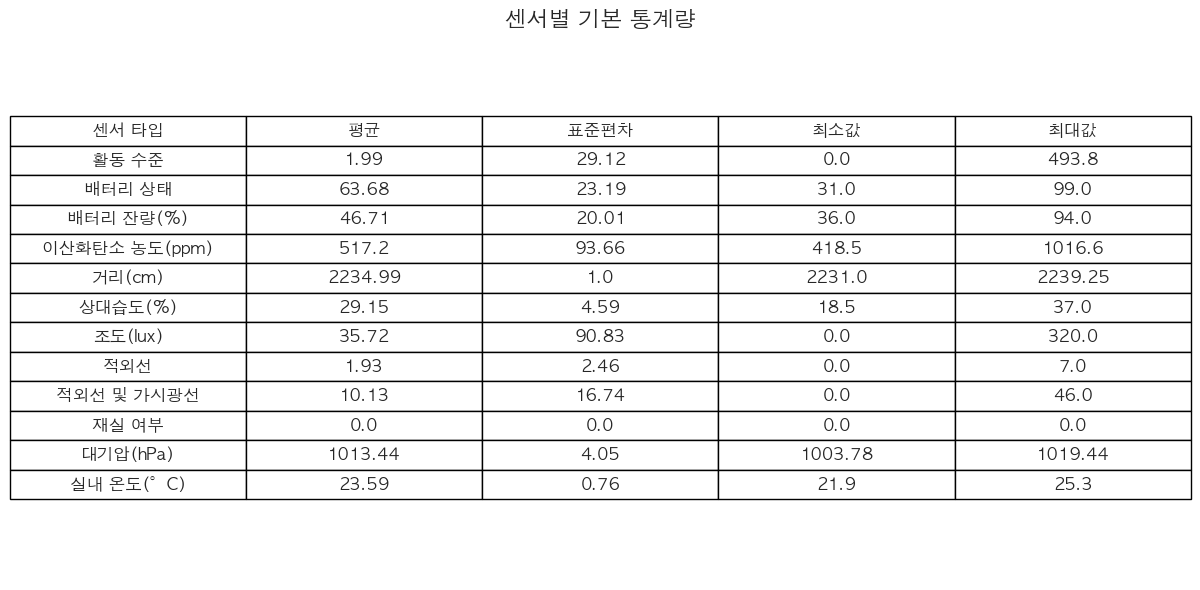

In [21]:
# 센서별 기술 통계량 계산
stats_df = df.groupby('type')['_value'].agg(['mean', 'std', 'min', 'max']).reset_index()

# 한글 변수명으로 변경
stats_df['type'] = stats_df['type'].map(sensor_type_mapping)

# 통계량 소수점 조정
stats_df['mean'] = stats_df['mean'].round(2)
stats_df['std'] = stats_df['std'].round(2)
stats_df['min'] = stats_df['min'].round(2)
stats_df['max'] = stats_df['max'].round(2)

# 대안: Figure 객체에 Axes 추가
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=stats_df.values, 
                colLabels=['센서 타입', '평균', '표준편차', '최소값', '최대값'],
                loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title('센서별 기본 통계량', fontsize=16)
plt.tight_layout()
plt.savefig('img/센서별_통계량.png', dpi=300, bbox_inches='tight')
plt.show()



# 변수 분포 확인

In [22]:
main_sensors = ['temperature', 'humidity', 'co2', 'illumination', 'pressure']

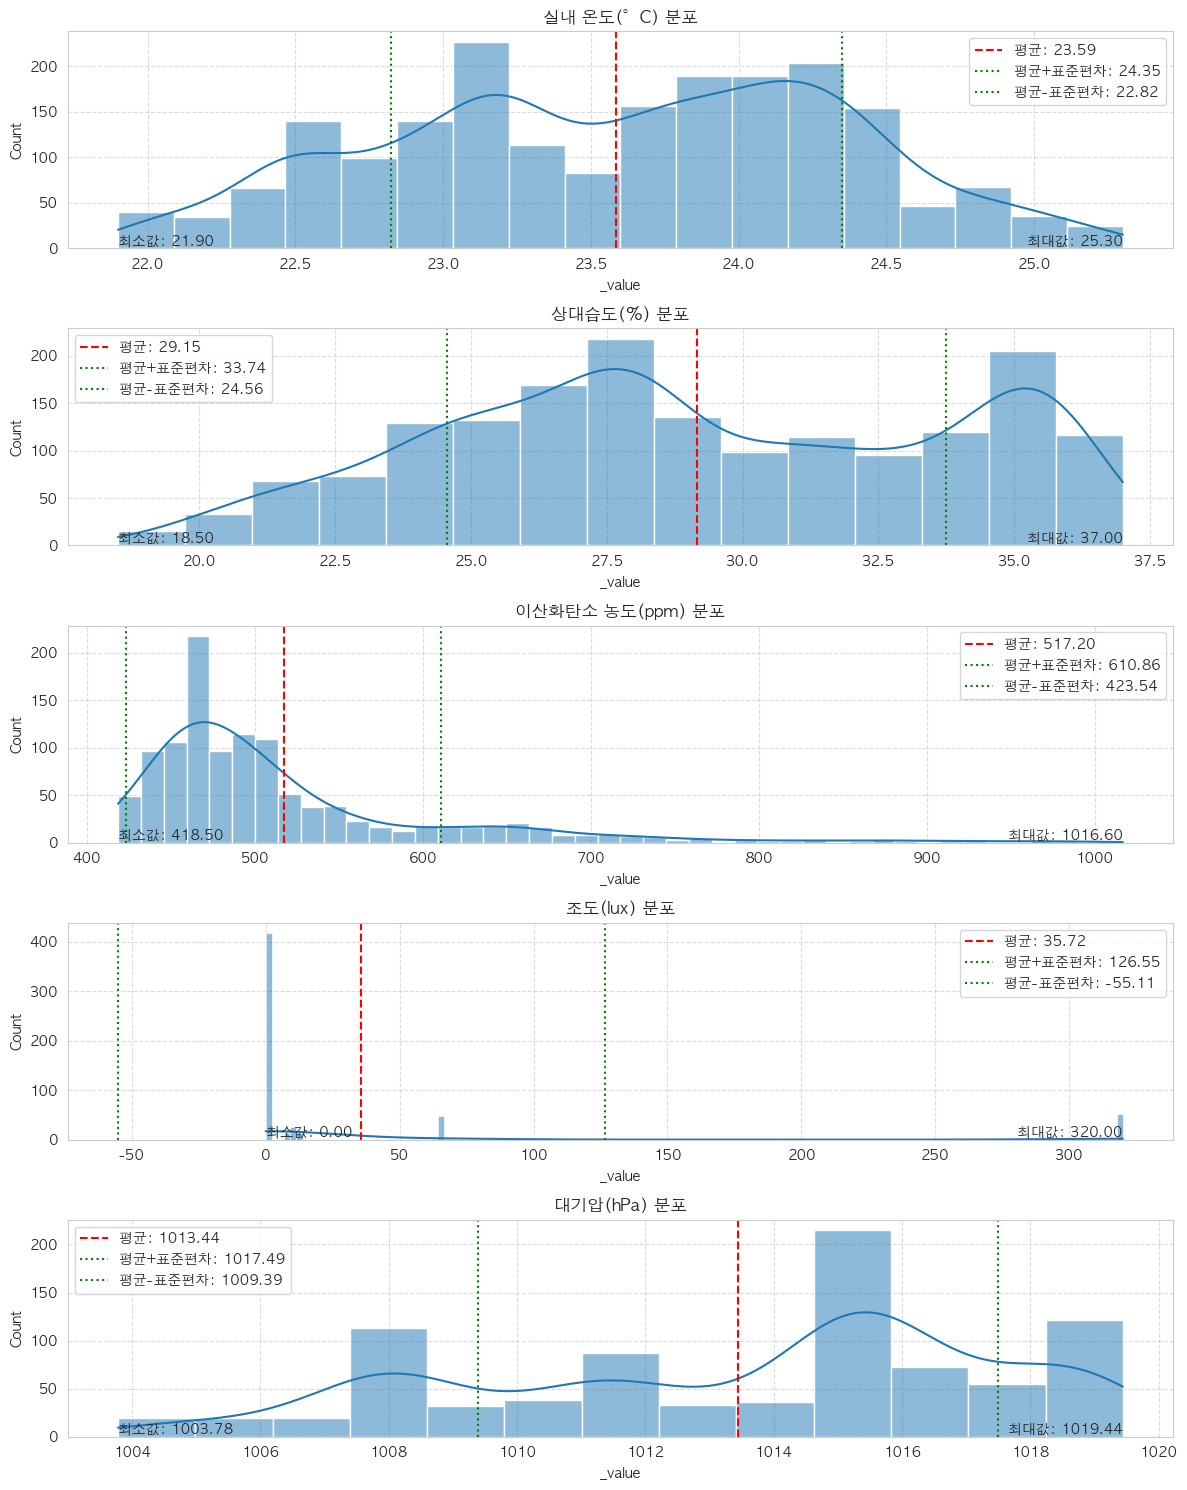

In [23]:
# 주요 센서에 대한 히스토그램 생성
fig, axes = plt.subplots(len(main_sensors), 1, figsize=(12, 3*len(main_sensors)))

for i, sensor in enumerate(main_sensors):
    subset = df[df['type'] == sensor]
    
    # 히스토그램 그리기
    sns.histplot(subset['_value'], ax=axes[i], kde=True)
    
    # 평균, 표준편차 표시 라인 추가
    mean_val = subset['_value'].mean()
    std_val = subset['_value'].std()
    
    axes[i].axvline(mean_val, color='r', linestyle='--', label=f'평균: {mean_val:.2f}')
    axes[i].axvline(mean_val + std_val, color='g', linestyle=':', label=f'평균+표준편차: {mean_val+std_val:.2f}')
    axes[i].axvline(mean_val - std_val, color='g', linestyle=':', label=f'평균-표준편차: {mean_val-std_val:.2f}')
    
    # 최대/최소값 표시
    min_val = subset['_value'].min()
    max_val = subset['_value'].max()
    
    axes[i].text(min_val, 0, f'최소값: {min_val:.2f}', ha='left', va='bottom')
    axes[i].text(max_val, 0, f'최대값: {max_val:.2f}', ha='right', va='bottom')
    
    # 제목 및 범례 설정
    axes[i].set_title(f'{sensor_type_mapping.get(sensor, sensor)} 분포')
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('img/변수_분포도.png', dpi=300, bbox_inches='tight')
plt.show()


In [24]:
# 시간대 구분
df['hour'] = df.index.hour
time_periods = {
    '새벽(0-6시)': (0, 6),
    '아침(6-12시)': (6, 12),
    '오후(12-18시)': (12, 18),
    '저녁(18-24시)': (18, 24)
}

# 주요 센서에 대한 시간대별 통계량 계산
time_stats = []

for sensor in main_sensors:
    sensor_df = df[df['type'] == sensor]
    
    for period_name, (start, end) in time_periods.items():
        period_data = sensor_df[(sensor_df['hour'] >= start) & (sensor_df['hour'] < end)]
        
        if not period_data.empty:
            stats = {
                '센서': sensor_type_mapping.get(sensor, sensor),
                '시간대': period_name,
                '평균': period_data['_value'].mean(),
                '표준편차': period_data['_value'].std(),
                '최소값': period_data['_value'].min(),
                '최대값': period_data['_value'].max()
            }
            time_stats.append(stats)

# 데이터프레임으로 변환
time_stats_df = pd.DataFrame(time_stats)



/var/folders/lf/y10g6sqx1r31qpbktbvwk_f00000gn/T/ipykernel_10643/2477480971.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/lf/y10g6sqx1r31qpbktbvwk_f00000gn/T/ipykernel_10643/2477480971.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/lf/y10g6sqx1r31qpbktbvwk_f00000gn/T/ipykernel_10643/2477480971.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/lf/y10g6sqx1r31qpbktbvwk_f00000gn/T/ipykernel_10643/2477480971.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

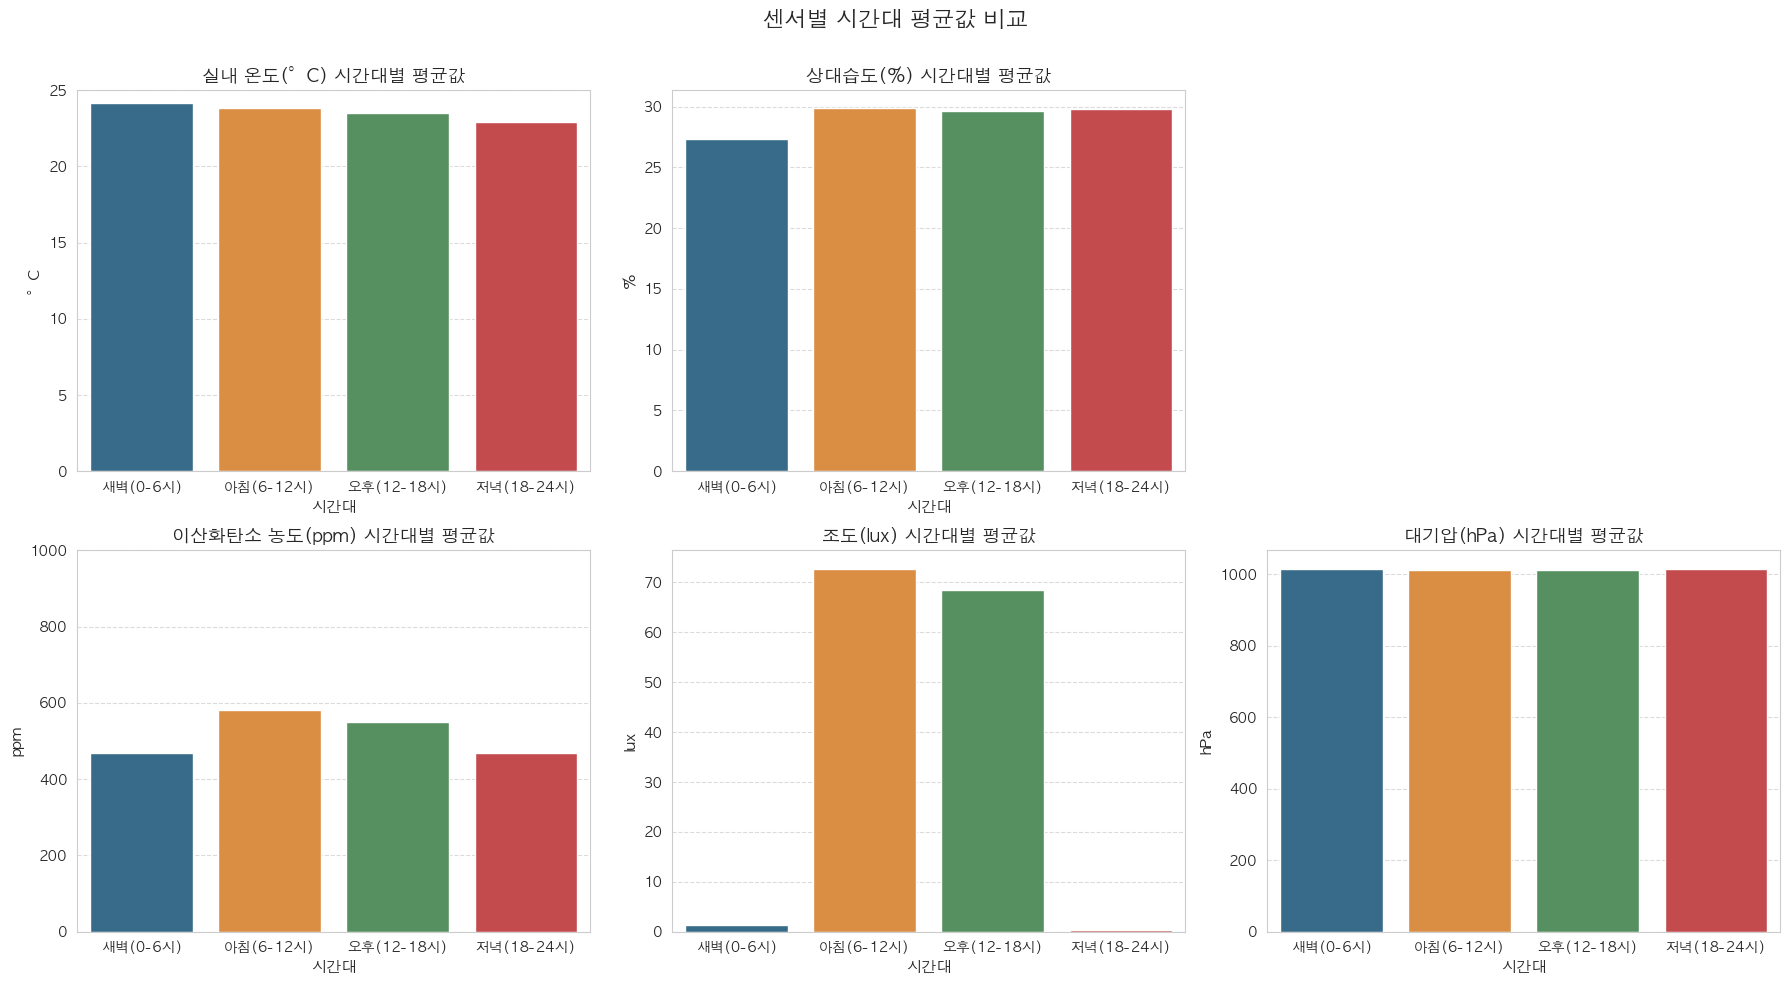

In [25]:
# 서브플롯 레이아웃 설정 (2행 3열)
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 3, figure=fig)

# 센서 이름과 그리드 위치 매핑
sensor_positions = {
    '실내 온도(°C)': (0, 0),    # 1행 1열
    '상대습도(%)': (0, 1),      # 1행 2열
    '이산화탄소 농도(ppm)': (1, 0),  # 2행 1열
    '조도(lux)': (1, 1),        # 2행 2열
    '대기압(hPa)': (1, 2)       # 2행 3열
}

# 시간대별 색상 지정
time_colors = {
    '새벽(0-6시)': '#2a6f97',
    '아침(6-12시)': '#f28e2b',
    '오후(12-18시)': '#4e9959',
    '저녁(18-24시)': '#d7373b'
}

# 각 센서별 서브플롯 생성
for sensor_name, (row, col) in sensor_positions.items():
    # 해당 센서 데이터 필터링
    sensor_data = time_stats_df[time_stats_df['센서'] == sensor_name]
    
    if not sensor_data.empty:
        # 서브플롯 생성
        ax = fig.add_subplot(gs[row, col])
        
        # 막대 그래프 생성
        sns.barplot(
            x='시간대', 
            y='평균', 
            data=sensor_data, 
            ax=ax,
            palette=time_colors
        )
        
        # 그래프 설정
        ax.set_title(f'{sensor_name} 시간대별 평균값', fontsize=13)
        ax.set_xlabel('시간대', fontsize=11)
        
        # 단위 추출하여 y축 레이블에 설정
        if '(' in sensor_name:
            unit = sensor_name.split('(')[-1].replace(')', '')
            ax.set_ylabel(f'{unit}', fontsize=11)
        else:
            ax.set_ylabel('평균값', fontsize=11)
        
        # 그리드 추가
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # y축 제한 설정 (필요한 경우)
        if sensor_name == '실내 온도(°C)':
            ax.set_ylim(0, 25)
        elif sensor_name == '이산화탄소 농도(ppm)':
            ax.set_ylim(0, 1000)

# 첫 번째 행의 빈 공간 숨기기
fig.delaxes(fig.add_subplot(gs[0, 2]))

# 전체 제목 설정
plt.suptitle('센서별 시간대 평균값 비교', fontsize=16, y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # 전체 제목 공간 확보
plt.savefig('img/센서별_시간대_평균값_행열구분.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
print(df)

                           index result  table  \
time                                             
2025-04-25 09:45:00+00:00      0   mean      0   
2025-04-25 09:50:00+00:00      1   mean      0   
2025-04-25 09:55:00+00:00      2   mean      0   
2025-04-25 10:00:00+00:00      3   mean      0   
2025-04-25 10:05:00+00:00      4   mean      0   
...                          ...    ...    ...   
2025-04-26 09:00:00+00:00   8940   mean     40   
2025-04-26 09:05:00+00:00   8941   mean     40   
2025-04-26 09:20:00+00:00   8942   mean     40   
2025-04-26 09:25:00+00:00   8943   mean     40   
2025-04-26 09:35:00+00:00   8944   mean     40   

                                                    _start  \
time                                                         
2025-04-25 09:45:00+00:00 2025-04-25 09:44:32.162940+00:00   
2025-04-25 09:50:00+00:00 2025-04-25 09:44:32.162940+00:00   
2025-04-25 09:55:00+00:00 2025-04-25 09:44:32.162940+00:00   
2025-04-25 10:00:00+00:00 2025-04-25 09

# 